In [26]:
# Imports
import torch as nn
from torchvision import datasets, transforms
import numpy as np
from  matplotlib import pyplot as plt
from torchvision.transforms import functional as F

In [34]:
path = "./data/"
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(path, transform=transform)
dataloader = nn.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

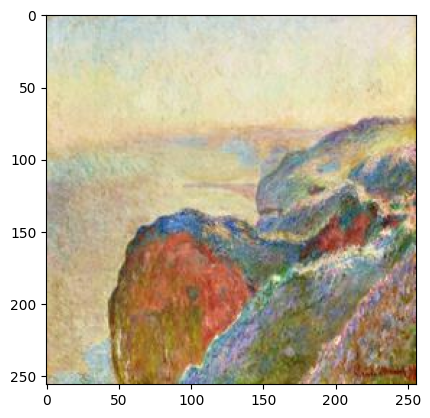

In [36]:
plt.imshow(F.to_pil_image(dataset[0][0]))
plt.show()